In [16]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import random
import numpy as np

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device using: ", device)

device using:  cuda


In [18]:
def set_seed(seed=42):

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 
    np.random.seed(seed)
    random.seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [ ]:
import os, shutil
from PIL import Image

src = "/kaggle/input/microsoft-catsvsdogs-dataset/PetImages"
dst = "/kaggle/working/PetImages"

if not os.path.exists(dst):
    shutil.copytree(src, dst)

# Now clean in /kaggle/working
for category in ["Cat", "Dog"]:
    folder = os.path.join(dst, category) 
    for file in os.listdir(folder): 
        fpath = os.path.join(folder, file)
        try:
            img = Image.open(fpath)
            img.verify()
        except:
            os.remove(fpath)

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),  
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # standard ImageNet normalization
])

In [21]:
val_test_transform = transforms.Compose([transforms.Resize((128,128)),
                                        transforms.ToTensor(), 
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [22]:
dataset = datasets.ImageFolder(root=dst)

In [23]:
print(len(dataset))

24998


In [24]:
print(dataset.classes)

['Cat', 'Dog']


In [25]:
train_size = int(0.7*len(dataset))
val_size = int(0.1*len(dataset))
test_size = len(dataset) - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

In [26]:
# Custom wrapper
class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
    
    def __getitem__(self, idx):
        x, y = self.subset[idx]
        if self.transform:
            x = self.transform(x)
        return x, y
    
    def __len__(self):
        return len(self.subset)

train_dataset = TransformDataset(train_set, train_transform)
val_dataset = TransformDataset(val_set, val_test_transform)
test_dataset = TransformDataset(test_set, val_test_transform)

In [27]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=3, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64,  num_workers=3, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64,  num_workers=3, pin_memory=True)

In [ ]:
class PetNet(nn.Module):
    def __init__(self, num_channels):
        super().__init__()
        self.features_extractor = nn.Sequential(
            nn.Conv2d(num_channels, 32, kernel_size=3, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding='same'),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding='same'),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding='same'),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding='same'),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding='same'),
            nn.MaxPool2d(kernel_size=2, stride=2)
            
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)), #now u dont need to worry about the size of input image
            nn.Flatten(),   #without adaptivepool there would be 1,31,072 input nodes thus increasing computation and training time
            nn.Linear(512*1*1, 128), 
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128,64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64,2)
        )

    def forward(self, x):
        x = self.features_extractor(x)
        x = self.classifier(x)
        return x

In [29]:
Pet = PetNet(3).to(device)
optimizer = optim.Adam(Pet.parameters(), lr=1e-3)
Loss = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, min_lr=1e-6)

In [30]:
epochs = 100
es_patience = 14
counter = 0
best_val_loss = float('inf')     #float('inf') is basically Python’s way of saying “this number is larger than anything I can represent” → i.e. positive infinity
delta=1e-4

for epoch in range(epochs):
    Pet.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = Pet(images)
        loss = Loss(outputs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    #Validation part
    total_val_loss=0
    Pet.eval()
    total_samples = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = Pet(images)
            loss = Loss(outputs, labels) # mean loss per sample
            total_val_loss += loss*labels.size(0) #total loss per batch in each loop, eventually at the end, total loss on whole data
            total_samples += labels.size(0)
        avg_val_loss = total_val_loss / total_samples
        scheduler.step(avg_val_loss)

    #Early stopping
    if avg_val_loss < best_val_loss-delta:
        best_val_loss = avg_val_loss
        torch.save(Pet.state_dict(), "best_model_trial.pth")
        counter=0
    else:
        counter+=1
        if counter>es_patience:
            print("Early stopping triggered.")
            break
    print(f"Epoch:{(epoch+1)}/{epochs} | Val_loss: {avg_val_loss:.4f} | Patience Counter: {counter}")

Epoch:1/100 | Val_loss: 0.8335 | Patience Counter: 0
Epoch:2/100 | Val_loss: 0.6038 | Patience Counter: 0
Epoch:3/100 | Val_loss: 0.6834 | Patience Counter: 1
Epoch:4/100 | Val_loss: 0.4385 | Patience Counter: 0
Epoch:5/100 | Val_loss: 0.4455 | Patience Counter: 1
Epoch:6/100 | Val_loss: 0.4116 | Patience Counter: 0
Epoch:7/100 | Val_loss: 0.3306 | Patience Counter: 0
Epoch:8/100 | Val_loss: 0.3336 | Patience Counter: 1
Epoch:9/100 | Val_loss: 0.3549 | Patience Counter: 2
Epoch:10/100 | Val_loss: 0.3881 | Patience Counter: 3
Epoch:11/100 | Val_loss: 0.4386 | Patience Counter: 4
Epoch:12/100 | Val_loss: 0.1720 | Patience Counter: 0
Epoch:13/100 | Val_loss: 0.1539 | Patience Counter: 0
Epoch:14/100 | Val_loss: 0.1997 | Patience Counter: 1
Epoch:15/100 | Val_loss: 0.1459 | Patience Counter: 0
Epoch:16/100 | Val_loss: 0.1393 | Patience Counter: 0
Epoch:17/100 | Val_loss: 0.1440 | Patience Counter: 1
Epoch:18/100 | Val_loss: 0.1568 | Patience Counter: 2
Epoch:19/100 | Val_loss: 0.1384 | Pat

In [31]:
#Testing
Pet.eval()
correct=0
total=0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = Pet(images)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.size(0)
        correct+=(predicted==labels).sum().item()
    test_accuracy=100*correct/total
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    

Test Accuracy: 96.58%


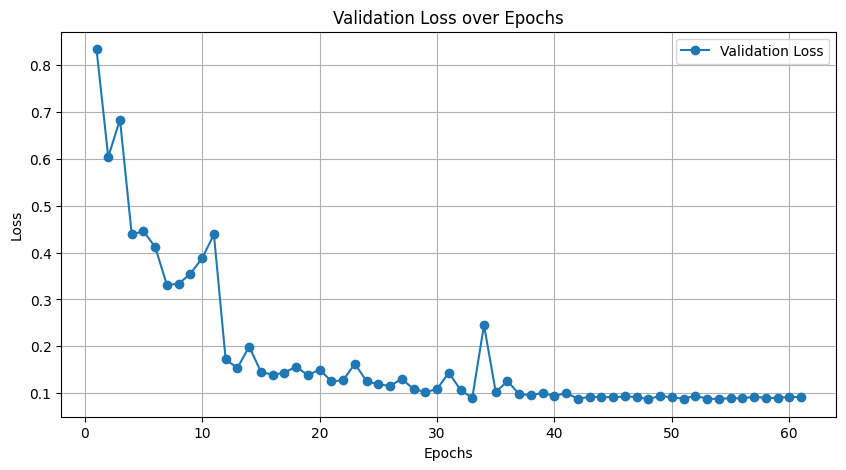

In [ ]:
import matplotlib.pyplot as plt

val_loss = [0.8335, 0.6038, 0.6834, 0.4385, 0.4455, 0.4116, 0.3306, 0.3336, 0.3549, 0.3881,
            0.4386, 0.1720, 0.1539, 0.1997, 0.1459, 0.1393, 0.1440, 0.1568, 0.1384, 0.1504,
            0.1258, 0.1273, 0.1631, 0.1257, 0.1189, 0.1158, 0.1306, 0.1091, 0.1026, 0.1087,
            0.1441, 0.1071, 0.0900, 0.2454, 0.1025, 0.1260, 0.0981, 0.0961, 0.1007, 0.0941,
            0.1007, 0.0882, 0.0925, 0.0920, 0.0915, 0.0932, 0.0921, 0.0873, 0.0947, 0.0911,
            0.0885, 0.0947, 0.0884, 0.0878, 0.0898, 0.0889, 0.0929, 0.0900, 0.0901, 0.0922,
            0.0921]

epochs = list(range(1, len(val_loss)+1))

plt.figure(figsize=(10,5))
plt.plot(epochs, val_loss, marker='o', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Validation Loss over Epochs")
plt.grid(True)
plt.legend()
plt.show()


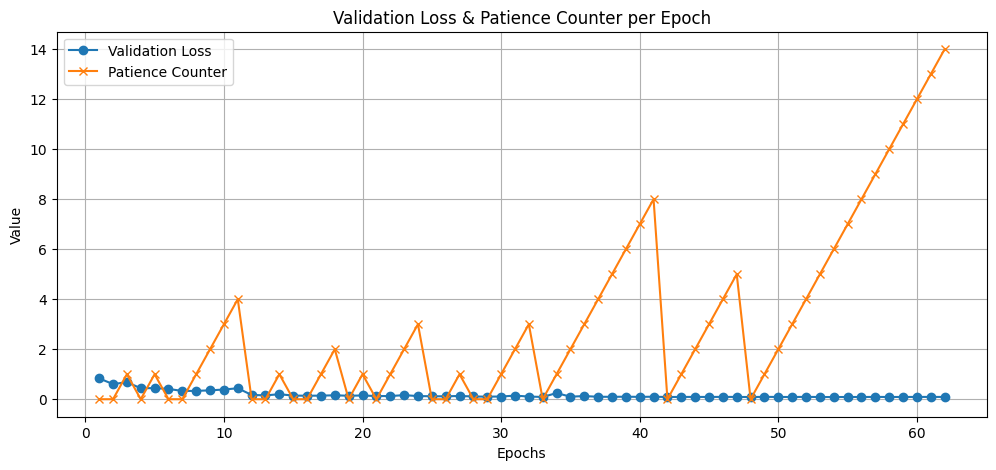

In [ ]:
import re
import matplotlib.pyplot as plt


log_text = """
Epoch:1/100 | Val_loss: 0.8335 | Patience Counter: 0
Epoch:2/100 | Val_loss: 0.6038 | Patience Counter: 0
Epoch:3/100 | Val_loss: 0.6834 | Patience Counter: 1
Epoch:4/100 | Val_loss: 0.4385 | Patience Counter: 0
Epoch:5/100 | Val_loss: 0.4455 | Patience Counter: 1
Epoch:6/100 | Val_loss: 0.4116 | Patience Counter: 0
Epoch:7/100 | Val_loss: 0.3306 | Patience Counter: 0
Epoch:8/100 | Val_loss: 0.3336 | Patience Counter: 1
Epoch:9/100 | Val_loss: 0.3549 | Patience Counter: 2
Epoch:10/100 | Val_loss: 0.3881 | Patience Counter: 3
Epoch:11/100 | Val_loss: 0.4386 | Patience Counter: 4
Epoch:12/100 | Val_loss: 0.1720 | Patience Counter: 0
Epoch:13/100 | Val_loss: 0.1539 | Patience Counter: 0
Epoch:14/100 | Val_loss: 0.1997 | Patience Counter: 1
Epoch:15/100 | Val_loss: 0.1459 | Patience Counter: 0
Epoch:16/100 | Val_loss: 0.1393 | Patience Counter: 0
Epoch:17/100 | Val_loss: 0.1440 | Patience Counter: 1
Epoch:18/100 | Val_loss: 0.1568 | Patience Counter: 2
Epoch:19/100 | Val_loss: 0.1384 | Patience Counter: 0
Epoch:20/100 | Val_loss: 0.1504 | Patience Counter: 1
Epoch:21/100 | Val_loss: 0.1258 | Patience Counter: 0
Epoch:22/100 | Val_loss: 0.1273 | Patience Counter: 1
Epoch:23/100 | Val_loss: 0.1631 | Patience Counter: 2
Epoch:24/100 | Val_loss: 0.1257 | Patience Counter: 3
Epoch:25/100 | Val_loss: 0.1189 | Patience Counter: 0
Epoch:26/100 | Val_loss: 0.1158 | Patience Counter: 0
Epoch:27/100 | Val_loss: 0.1306 | Patience Counter: 1
Epoch:28/100 | Val_loss: 0.1091 | Patience Counter: 0
Epoch:29/100 | Val_loss: 0.1026 | Patience Counter: 0
Epoch:30/100 | Val_loss: 0.1087 | Patience Counter: 1
Epoch:31/100 | Val_loss: 0.1441 | Patience Counter: 2
Epoch:32/100 | Val_loss: 0.1071 | Patience Counter: 3
Epoch:33/100 | Val_loss: 0.0900 | Patience Counter: 0
Epoch:34/100 | Val_loss: 0.2454 | Patience Counter: 1
Epoch:35/100 | Val_loss: 0.1025 | Patience Counter: 2
Epoch:36/100 | Val_loss: 0.1260 | Patience Counter: 3
Epoch:37/100 | Val_loss: 0.0981 | Patience Counter: 4
Epoch:38/100 | Val_loss: 0.0961 | Patience Counter: 5
Epoch:39/100 | Val_loss: 0.1007 | Patience Counter: 6
Epoch:40/100 | Val_loss: 0.0941 | Patience Counter: 7
Epoch:41/100 | Val_loss: 0.1007 | Patience Counter: 8
Epoch:42/100 | Val_loss: 0.0882 | Patience Counter: 0
Epoch:43/100 | Val_loss: 0.0925 | Patience Counter: 1
Epoch:44/100 | Val_loss: 0.0920 | Patience Counter: 2
Epoch:45/100 | Val_loss: 0.0915 | Patience Counter: 3
Epoch:46/100 | Val_loss: 0.0932 | Patience Counter: 4
Epoch:47/100 | Val_loss: 0.0921 | Patience Counter: 5
Epoch:48/100 | Val_loss: 0.0873 | Patience Counter: 0
Epoch:49/100 | Val_loss: 0.0947 | Patience Counter: 1
Epoch:50/100 | Val_loss: 0.0911 | Patience Counter: 2
Epoch:51/100 | Val_loss: 0.0885 | Patience Counter: 3
Epoch:52/100 | Val_loss: 0.0947 | Patience Counter: 4
Epoch:53/100 | Val_loss: 0.0884 | Patience Counter: 5
Epoch:54/100 | Val_loss: 0.0878 | Patience Counter: 6
Epoch:55/100 | Val_loss: 0.0898 | Patience Counter: 7
Epoch:56/100 | Val_loss: 0.0889 | Patience Counter: 8
Epoch:57/100 | Val_loss: 0.0929 | Patience Counter: 9
Epoch:58/100 | Val_loss: 0.0900 | Patience Counter: 10
Epoch:59/100 | Val_loss: 0.0901 | Patience Counter: 11
Epoch:60/100 | Val_loss: 0.0922 | Patience Counter: 12
Epoch:61/100 | Val_loss: 0.0921 | Patience Counter: 13
Epoch:62/100 | Val_loss: 0.0917 | Patience Counter: 14
Early stopping triggered.
"""

# Extract val_loss and patience counter using regex
val_loss = [float(x) for x in re.findall(r'Val_loss: ([0-9.]+)', log_text)]
patience_counter = [int(x) for x in re.findall(r'Patience Counter: (\d+)', log_text)]
epochs = list(range(1, len(val_loss)+1))

# Plot both
plt.figure(figsize=(12,5))
plt.plot(epochs, val_loss, marker='o', label='Validation Loss')
plt.plot(epochs, patience_counter, marker='x', label='Patience Counter')
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Validation Loss & Patience Counter per Epoch")
plt.grid(True)
plt.legend()
plt.show()
